In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""

df = pd.read_sql(query, conn)

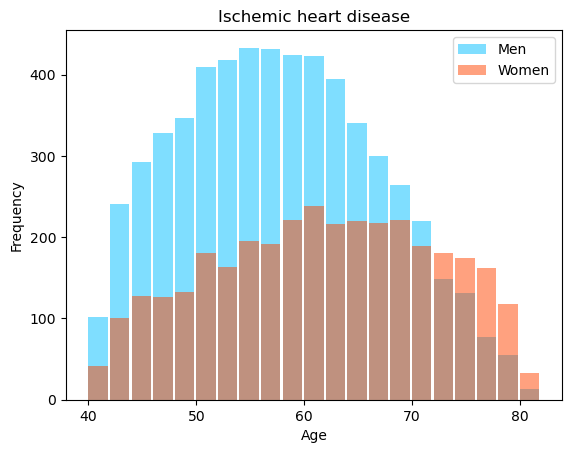

In [3]:
import matplotlib.pyplot as plt

wdf = df.where(df.gender == "F").dropna().groupby(['age', 'gender']).count().reset_index()
mdf = df.where(df.gender == "M").dropna().groupby(['age', 'gender']).count().reset_index()
xWomen = wdf["age"]
yWomen = wdf["patient"]
xMen = mdf["age"]
yMen = mdf["patient"]

plt.bar(xMen, yMen, width=1.8, align='edge', label='Men', alpha=0.5, color='deepskyblue')
plt.bar(xWomen, yWomen, width=1.8, align='edge', label='Women', alpha=0.5, color='orangered')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ischemic heart disease')
plt.legend()
plt.show()

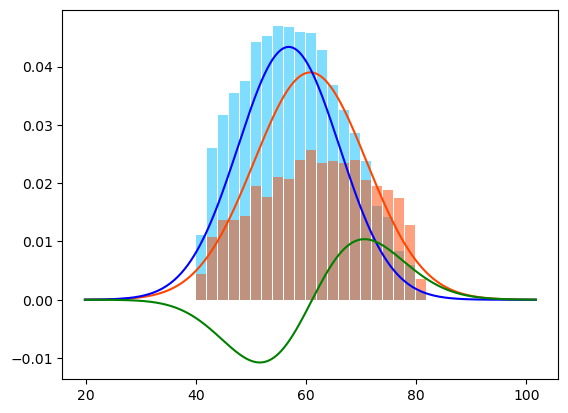

In [5]:
import statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

femaleData = []
fSum = 0
for i in range(len(yWomen)):
    count = yWomen[i]
    fSum += count
    age = xWomen[i]
    for j in range(count):
        femaleData.append(age)

maleData = []
mSum = 0
for i in range(len(yMen)):
    count = yMen[i]
    mSum += count
    age = xMen[i]
    for j in range(count):
        maleData.append(age)

fMean = statistics.mean(femaleData)
wStdDev = statistics.pstdev(femaleData, fMean)

x_axis = np.arange(fMean-(4*wStdDev), fMean+(4*wStdDev), 0.01)
wDist = norm.pdf(x_axis, fMean, wStdDev)
plt.plot(x_axis, wDist, color='orangered')

mMean = statistics.mean(maleData)
mStdDev = statistics.pstdev(maleData, mMean)

# x_axis = np.arange(mMean-(4*mStdDev), mMean+(4*mStdDev), 0.01)
mDist = norm.pdf(x_axis, mMean, mStdDev)
plt.plot(x_axis, mDist, color='blue')

plt.plot(x_axis, wDist - mDist, color='green')


plt.bar(xMen, yMen/(mSum+fSum), width=1.8, align='edge', label='Men', alpha=0.5, color='deepskyblue')
plt.bar(xWomen, yWomen/(fSum+mSum), width=1.8, align='edge', label='Women', alpha=0.5, color='orangered')

plt.show()

# Cohen's D

In [ ]:
# calculate the Cohen's d between two samples
from numpy import mean
from numpy import var
from math import sqrt

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

dBDP = cohend(femaleData, maleData)
print("Before DP, for men and women: ", dBDP)

In [ ]:
import snsql
from snsql import Privacy

metadata = {
    '':{
        '': {
            'MyTable': {
                'max_ids': 1,
                'row_privacy': True,
                'patient': {
                    'name': 'patient',
                    'type': 'string'
                },
                'age': {
                    'name': 'age',
                    'type': 'int'
                },
                'gender': {
                    'name': 'gender',
                    'type': 'string'
                }
            }
        }
    }
}

privacy = Privacy(epsilon=0.1, delta=1)
reader = snsql.from_connection(df, privacy=privacy, metadata=metadata)

r = reader.execute('SELECT gender, age, COUNT(patient) as amount FROM MyTable GROUP BY gender, age')[1:]
print(r)

In [ ]:
femaleDataDP = []
fSumDP = 0
maleDataDP = []
mSumDP = 0

for i in range(len(r)):
    if r[i][0] == 'F':
        fSumDP += r[i][2]
    else:
        mSumDP += r[i][2]

    age = r[i][1]
    count = r[i][2]
    for j in range(count):
        if r[i][0] == 'F':
            femaleDataDP.append(age)
        else:
            maleDataDP.append(age)

fMeanDP = statistics.mean(femaleDataDP)
fStdDevDP = statistics.pstdev(femaleDataDP, fMeanDP)

x_axis = np.arange(fMeanDP-(4*fStdDevDP), fMeanDP+(4*fStdDevDP), 0.01)
plt.plot(x_axis, norm.pdf(x_axis, fMeanDP, fStdDevDP), color='orangered')

mMeanDP = statistics.mean(maleDataDP)
mStdDevDP = statistics.pstdev(maleDataDP, mMeanDP)

x_axis = np.arange(mMeanDP-(4*mStdDevDP), mMean+(4*mStdDevDP), 0.01)
plt.plot(x_axis, norm.pdf(x_axis, mMeanDP, mStdDevDP), color='blue')
plt.show()

dWDP = cohend(femaleDataDP, maleDataDP)
print("After DP, for male and women :", dWDP)

# Multiple runs

In [ ]:
privacy = Privacy(epsilon=0.05, delta=1)

arrayOfMenCohenD = []

for x in range(500):
    reader = snsql.from_connection(df, privacy=privacy, metadata=metadata)

    r = reader.execute('SELECT gender, age, COUNT(patient) as amount FROM MyTable GROUP BY gender, age')[1:]

    femaleDataDP = []
    maleDataDP = []

    for i in range(len(r)):
        age = r[i][1]
        count = r[i][2]
        for j in range(count):
            if r[i][0] == 'F':
                femaleDataDP.append(age)
            else:
                maleDataDP.append(age)

    arrayOfMenCohenD.append(cohend(femaleDataDP, maleDataDP))

plt.hist(arrayOfMenCohenD)
plt.show()